In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
from os import listdir

import root_pandas
from root_pandas import read_root
from root_pandas import to_root 

Welcome to JupyROOT 6.15/01


## beam parameters, 

In [2]:
mass_proton = 0.938
E_proton    = 40
E_electron  = 5

In [3]:
class particle:
    def __init__(self, pid, fourvector, virtual_photon):
        
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,+E_electron,E_electron)
    
        self.proton = ROOT.TLorentzVector()
        self.proton.SetPxPyPzE(0,0,-E_proton, E_proton)
        
        self.virtual_photon = virtual_photon 
        Nu = virtual_photon.E()
        Q2 = -virtual_photon.M2()
        self.W = (virtual_photon + self.proton).M()
        part1 = virtual_photon.Vect().Cross(incoming_e.Vect()).Unit()
        part2 = virtual_photon.Vect().Cross(fourvector.Vect()).Unit()
        sign  = np.sign(part1.Dot(fourvector.Vect()))
        self.PhiPQ = sign*np.arccos(part1.Dot(part2))
        
        self.LorentzVector = fourvector #hadron four-vector ()
        self.PhiLab = self.LorentzVector.Phi()
        self.E = self.LorentzVector.E() #energy in lab frame
        self.vector = self.LorentzVector.Vect()
        self.Pt = self.vector.Perp(virtual_photon.Vect().Unit()) #pT with respect to photon direction
        self.pid = pid
        self.Zh = fourvector.Dot(self.proton)/virtual_photon.Dot(self.proton)

    def print_properties(self):
        print 'Hello, let me introduce myself, i am particle pid = ' , self.pid
        print 'zh = ', self.Zh, ' phi_pq= ', self.PhiPQ, ' theta_pq=' , self.ThetaPQ, 'E = ', self.E, ' xf', self.Xf,'Pt ', self.Pt, ' Pl= ', self.Pl, ' rapidity=' ,  self.y


In [4]:
class mytupla:
    def __init__(self):
        hadron_variables = ['pid','z','pt','E','Q2','x','Nu','y','W','phi_pq','TargType']
        
        self.tupla_hadron = {}
        for var in hadron_variables:
            self.tupla_hadron[var] = []    
            
            
        electron_variables = ['Q2','x','Nu','y','s','E']
        
        self.tupla_electron = {}
        for var in electron_variables:
            self.tupla_electron[var] = []    

In [5]:

def getDataframes(filename, Target=1,maxevents=1e9):
        
    dphi = np.array([])
    ParticlesFromPrevious = []
    try:
        myfile = TFile.Open('%s'%filename,'READ')
    except:
        print("could not open file")

        
    myfile.Print()
    mytree = myfile.Get('RootTuple')
    
    print filename, ' has ', mytree.GetEntries(), ' entries'
    print 'The max number of events to be analyzes is ', maxevents
    df = mytupla()    
    
    start = time.time()
    for ievt  in range(mytree.GetEntries()):
        if(ievt%1e5==0):
            print 'Event # ', ievt
            end = time.time()
            print 'Processed in',  end-start, 'seconds'
            start = time.time()
        mytree.GetEntry(ievt)   
        if mytree.Q2<1.0: continue
        if ievt>maxevents: break
        Nu = mytree.nu
        Q2 = mytree.Q2
        x  = Q2/(2*mass_proton*Nu)
        s  = 4*E_electron*E_proton
        y  = Q2/(s*x)
        #print'correct inelasticity', y
        #print 'correct nu', Nu
        #print ' correct x ', x
        phi_e = mytree.phiL 
        Eprime = Q2/(4*E_electron) + (1-y)*E_electron
        
        incoming_e = ROOT.TLorentzVector()
        incoming_e.SetPxPyPzE(0,0,+E_electron,E_electron)
    
        proton = ROOT.TLorentzVector()
        proton.SetPxPyPzE(0,0,-E_proton, E_proton)
    
        #scattered electron in the lab frame
        scattered_e = ROOT.TLorentzVector()
        cos_thetae = 1-Q2/(2*E_electron*Eprime)
        sin_thetae = np.sqrt(1-cos_thetae*cos_thetae)
        #This is the electron in the lab frame
        scattered_e.SetPxPyPzE(Eprime*sin_thetae*np.cos(phi_e),
                               Eprime*sin_thetae*np.sin(phi_e),
                               Eprime*cos_thetae,
                               Eprime)
        #This is the virtual photon in the lab frame
        virtual_photon  = incoming_e - scattered_e
        virtual_photon_unitvector = virtual_photon.Vect().Unit()

    
        df.tupla_electron['Q2'].append(Q2)
        df.tupla_electron['Nu'].append(Nu)
        df.tupla_electron['x'].append(x)
        df.tupla_electron['y'].append(y)
        df.tupla_electron['s'].append(np.sqrt(s))
        df.tupla_electron['E'].append(Eprime)

    
    
        ##Fill hadron
        
        for i in range(len(mytree.Px)):
            if (abs(mytree.barcode[i]) !=211 and abs(mytree.barcode[i]) !=321):  continue
            i_lv = ROOT.TLorentzVector()    
            i_lv.SetPxPyPzE(mytree.Px[i],mytree.Py[i],-mytree.Pz[i],mytree.E[i])
            i_part = particle(mytree.barcode[i], i_lv, virtual_photon)
            if i_part.Zh > 0.1: ##keep only particles with z
                df.tupla_hadron['TargType'].append(999)
                df.tupla_hadron['pid'].append(i_part.pid)
                df.tupla_hadron['z'].append(i_part.Zh)
                df.tupla_hadron['pt'].append(i_part.Pt)
                df.tupla_hadron['E'].append(i_part.E)

                df.tupla_hadron['phi_pq'].append(i_part.PhiPQ)
                df.tupla_hadron['Q2'].append(Q2)
                df.tupla_hadron['x'].append(x)
                df.tupla_hadron['Nu'].append(Nu)
                df.tupla_hadron['y'].append(y)
                df.tupla_hadron['W'].append(i_part.W)
   
            
    end = time.time()
    print 'Processed in',  end-start, 'seconds'
    df_hadron = pd.DataFrame(df.tupla_hadron)
    df_electron = pd.DataFrame(df.tupla_electron)

    return df_electron, df_hadron

In [6]:
df_hadron = {}
df_electron = {}

## produce data frames and Root files

In [7]:
df_electron['D'], df_hadron['D']= getDataframes('GiBUU_DEIC5_50.root',maxevents=1e9) 

GiBUU_DEIC5_50.root  has  40000  entries
The max number of events to be analyzes is  100000.0
Event #  0
Processed in 0.00272512435913 seconds
Processed in 115.872821093 seconds
TFile: name=GiBUU_DEIC5_50.root, title=, option=READ


In [9]:
df_electron['Au'], df_hadron['Au']= getDataframes('GiBUU_AuEIC5_50.root',maxevents=1e9)

GiBUU_AuEIC5_50.root  has  133960  entries
The max number of events to be analyzes is  1000000000.0
Event #  0
Processed in 0.00230097770691 seconds
Event #  100000
Processed in 377.356382847 seconds
Processed in 128.027366161 seconds
TFile: name=GiBUU_AuEIC5_50.root, title=, option=READ


## Check dataframes variables

40000


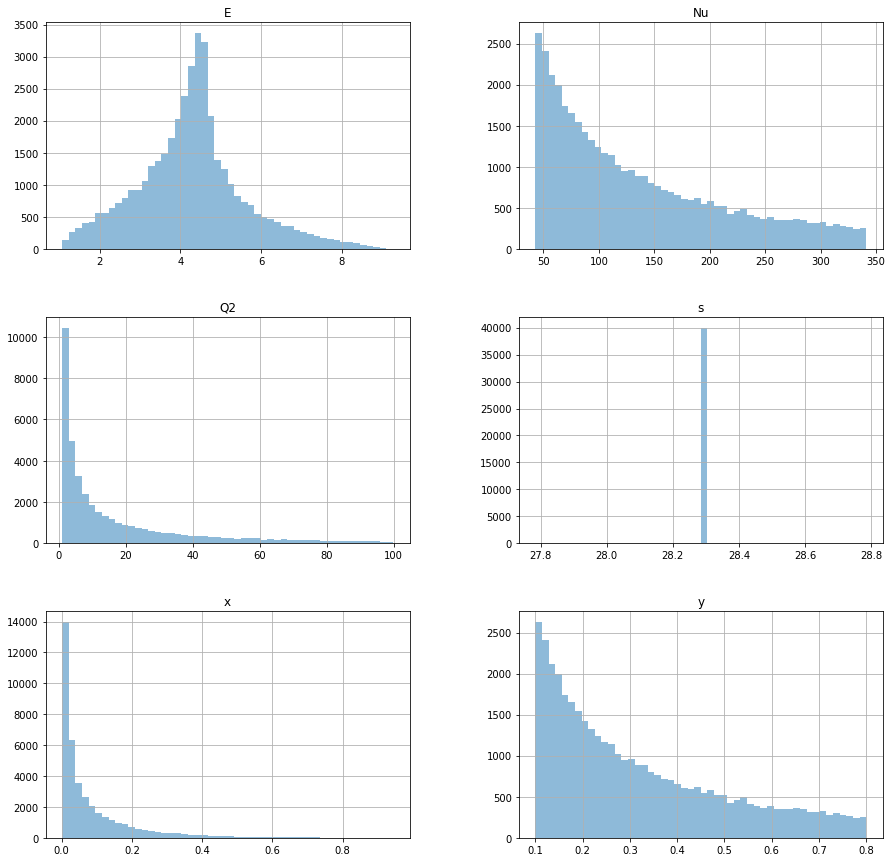

In [8]:
print df_electron['D'].shape[0]
df_electron['D'].hist(figsize=(15, 15),alpha=0.5,bins=50)
plt.show()

In [ ]:
print df_electron['Au'].shape[0]
df_electron['Au'].hist(figsize=(15, 15),alpha=0.5,bins=50)
plt.show()

In [ ]:
print df_hadron['Au'].shape[0]
df_hadron['Au'].hist(figsize=(15, 15),alpha=0.5,bins=50)
plt.show()

133960
40000


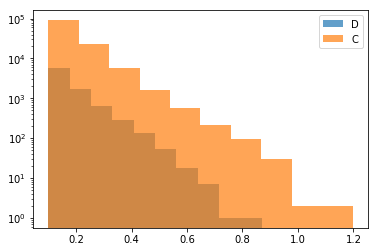

In [17]:
print df_electron['Au'].shape[0]
print df_electron['D'].shape[0]

y_D, x , _  = plt.hist(df_hadron['D']['z'],bins=10,alpha=0.7,label='D')
y_C, x , _  = plt.hist(df_hadron['Au']['z'],bins=10,alpha=0.7,label='C')


y_D = y_D/df_electron['D'].shape[0]
y_C = y_C/df_electron['Au'].shape[0]

x = (x[1:] + x[:-1])/2.0
plt.legend()
plt.yscale('log')
plt.show()

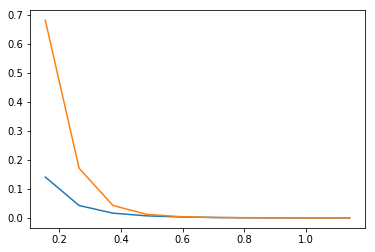

In [18]:
plt.errorbar(x = x, y=y_D)
plt.errorbar(x = x, y=y_C)

plt.show()

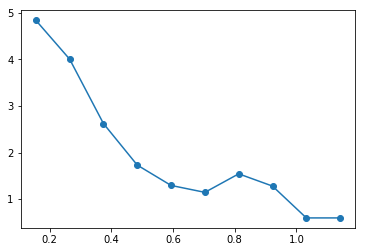

In [19]:
ratio = np.divide(y_C, y_D)
plt.errorbar(x, ratio, marker='o')

#plt.ylim([0.0,2.5])
plt.show()